In [8]:
import pickle
from PIL import Image
from sklearn.preprocessing import scale, minmax_scale
from scipy.ndimage import filters
from os import listdir, walk
from os.path import join, isfile
from scipy.misc import imresize
from support.dcmx import DICOMReader
from support.enorm import EnergyNormalization
import glob
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Constants

In [1]:
TRAIN_PATH = '../../data/train/'
TEST_PATH = '../../data/TbDispensary/'
PREFS = ['bases', 'masks', 'softs']


MODEL_PATH = '../Models/denoise_encoder_conv_X'
WEIGHTS_PATH = '../Models/denoise_encoder_conv_X_weights'
XGB_MODEL_PATH = '../Models/XGB.model'


DIM = 450
PATCH_DIM = 28
NORMALIZATION_ITERATION = 10

# JSRT PARAMS
JSRT_DIMS = 2048
JSRT_PATH = '../../data/All247images/'


NORMALISATION_B = 7
NORMALISATION_ALPHA = 2

# Feature extraction

In [10]:
def read(path='./', subdirs=[]): 
    return [asarray(Image.open(join(path, file)).convert('L')) / 1.
              for file in sorted(listdir(path)) if isfile(join(path, file))]


def preprocessing_for_normalized(img):
    shape = img.shape
    img = img - filters.gaussian_filter(img, 120)
    return scale(img.reshape(-1)).reshape(shape[0], -1)

Read train data

In [11]:
batches = dict()
for pref in PREFS:
    batches[pref] = read(join(TRAIN_PATH, pref))

for key in ['bases', 'softs']:
    batches[key] = [preprocessing_for_normalized(img) for img in batches[key]]

batches['bones'] = [base - soft 
                     for base, soft in zip(batches['bases'], batches['softs'])]

batches['masks'] = [minmax_scale(i.astype(float)) > 0
                 for i in batches['masks']]

Read test data

In [14]:
test = dict()
reader = DICOMReader()
test['bases'], test['masks'] = reader.extract_data(0, 10, TEST_PATH)

test['bases'] = [i for i in test['masks'] if i.sum()]
test['masks'] = [i for i in test['masks'] if i.sum()]

test['bases'] = [preprocessing_for_normalized(imresize(i, (DIM, DIM), "bicubic") / -1.) 
             for i in test['bases']]

test['masks'] = [minmax_scale(imresize(i, (DIM, DIM), "bicubic") / 1.) > 0
                 for i in test['masks']]

../../data/TbDispensary/
<generator object walk at 0x7fbb7243bba0>
step: ../../data/TbDispensary/image001.dcm  0
step: ../../data/TbDispensary/image002.dcm  1
step: ../../data/TbDispensary/image003.dcm  2
step: ../../data/TbDispensary/image004.dcm  3
step: ../../data/TbDispensary/image005.dcm  4
step: ../../data/TbDispensary/image006.dcm  5
step: ../../data/TbDispensary/image007.dcm  6
step: ../../data/TbDispensary/image008.dcm  7
step: ../../data/TbDispensary/image009.dcm  8
step: ../../data/TbDispensary/image010.dcm  9
step: ../../data/TbDispensary/image001.json  0
step: ../../data/TbDispensary/image002.json  1
step: ../../data/TbDispensary/image003.json  2
step: ../../data/TbDispensary/image004.json  3
step: ../../data/TbDispensary/image005.json  4
step: ../../data/TbDispensary/image006.json  5
Throwed
step: ../../data/TbDispensary/image007.json  6
Throwed
step: ../../data/TbDispensary/image008.json  7
step: ../../data/TbDispensary/image009.json  8
Throwed
step: ../../data/TbDispens

Step:  0
Step:  30
Step:  60
Step:  90
Step:  120
Step:  150
Step:  180
Step:  210
Step:  240


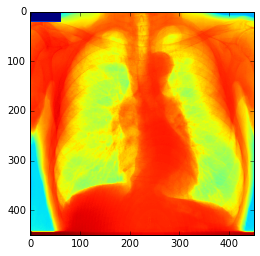

In [15]:
shape = (JSRT_DIMS, JSRT_DIMS) # matrix size
dtype = np.dtype('>u2') # big-endian unsigned integer (16bit)
energy = EnergyNormalization()
images = []
for i, file in enumerate(listdir(JSRT_PATH)):
    if isfile(join(JSRT_PATH, file)):
        # Reading.
        fid = open(join(JSRT_PATH, file), 'rb')
        data = fromfile(fid, dtype).astype(float)
        data = imresize(data.reshape(shape), (DIM, DIM), "bicubic")
        data = preprocessing_for_normalized(data / -1.)
        
        images.append(energy.iterate_normalization([data], 
                                            [test['masks'][0]], 
                                            batches['bases'], 
                                            batches['masks'], 
                                            5, 
                                            False)[0])
    if i % 30 == 0:
        print('Step: ', i)
        imshow(data)
        
jsrt = {
    'bases': asarray(images),
    'masks': asarray([ones(i[0].shape) for i in images])
}

Apply iterate normalization

In [ ]:
enorm = EnergyNormalization()
test['bases'] = enorm.iterate_normalization(test['bases'],
                                            test['masks'], 
                                            batches['bases'], 
                                            batches['masks'], 
                                            NORMALIZATION_ITERATION)

# CAE features extraction

Obtain pretrain denoising convolutonal encoder

In [6]:
from keras.models import load_model
encoder = load_model(MODEL_PATH)

/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/keras/models.py:136: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Prepare data for encoder

In [18]:
a = array([1, 3])
a[1:30]

array([3])

In [24]:
def cut_on_patches(images, masks, softs, dim=28):
    middle = int(dim / 2)
    over_patches = []
    target = []
    imgs_xs = []
    imgs_ys = []
    for img, mask, soft in zip(images, masks, softs):
        patches = []
        xs = []
        ys = []
        for x in range(np.shape(mask)[0] - dim):
            for y in range(np.shape(mask)[1] - dim):
                if mask[x: x + dim, y: y + dim].sum() > dim:
                    patches.append(img[x: x + dim, y: y + dim].reshape(dim, dim, 1))
                    target.append(soft[x + middle, y + middle])
                    xs.append(x + middle)
                    ys.append(y + middle)
        imgs_xs.append(xs)
        imgs_ys.append(ys)
        over_patches.append(patches)
    return asarray(over_patches), (imgs_xs, imgs_ys), asarray(target)

In [25]:
batches['patches'], batches['coords'], batches['targets'] = cut_on_patches(batches['bases'], 
                                                                          batches['masks'], 
                                                                          batches['bones'], 
                                                                          PATCH_DIM)

test['patches'], test['coords'], _ = cut_on_patches(test['bases'], 
                                                    test['masks'], 
                                                    test['bases'],
                                                    PATCH_DIM)

In [113]:
batches['patches'] = asarray([patch for img in batches['patches'] for patch in img])
test['patches'] = asarray([patch for img in test['patches'] for patch in img])

batches['patches'] = encoder.predict(batches['patches'])
test['patches'] = encoder.predict(test['patches'])

batches['patches'] = batches['patches'].reshape((batches['patches'].shape[0], -1))
test['patches']  = test['patches'].reshape((test['patches'] .shape[0], -1))

In [58]:
jsrt['patches'], jsrt['coords'], _ = cut_on_patches([jsrt['bases'][5][0]], 
                                                    [jsrt['masks'][5]], 
                                                    [jsrt['bases'][5][0]],
                                                    PATCH_DIM)
jsrt['patches'] = asarray([patch for img in jsrt['patches'] for patch in img])
jsrt['patches'] = encoder.predict(jsrt['patches'])
jsrt['patches']  = jsrt['patches'].reshape((jsrt['patches'] .shape[0], -1))

# Training and Testing

In [31]:
import xgboost as xgb
mp = {
        "booster": "gbtree",
        "objective": "reg:linear",
        "eta": 0.01,
        "max_depth": 7,
        "subsample": 0.75,
        "silent": 1,
        "seed": 0,
        "colsample_bytree": 0.82, 
        "n_estimators": 5000
    }

In [ ]:
data = xgb.DMatrix(batches['patches'][:-60000], batches['targets'][:-60000])
evallist  = [(data,'train'), (xgb.DMatrix(batches['patches'][-60000:], batches['targets'][-60000:]), 'eval')]

model = xgb.train(params=mp, 
                  dtrain=data, 
                  num_boost_round=5000, 
                  evals=evallist, 
                  early_stopping_rounds=17,
                 verbose_eval=100)

# model.save_model('DCNN_XGB' + str(NUM) + '.model')

# Stopping. Best iteration for 24 depth:
# [1170]    eval-rmse:0.119286

In [59]:
# model = xgb.Booster({'nthread':4}) #init model
# model.load_model(XGB_MODEL_PATH) # load data
predicted = model.predict(xgb.DMatrix(jsrt['patches']))

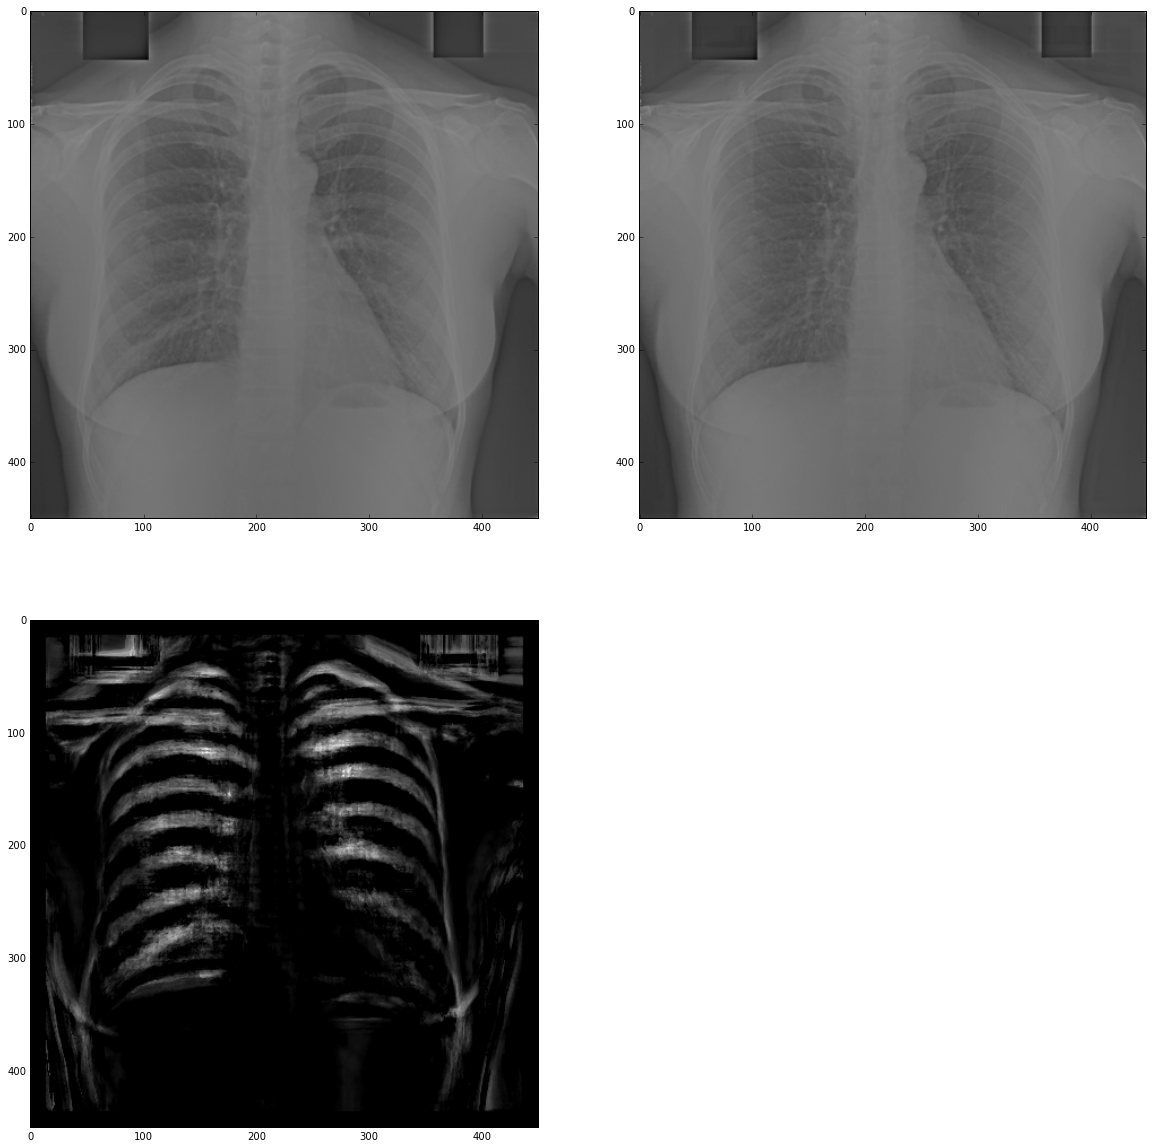

In [60]:
bone = zeros(jsrt['masks'][5].shape)
orig = jsrt['bases'][5][0]
bone[jsrt['coords']] = clip(predicted.reshape(-1,), 0, 10)
figure(figsize=(20,20));
subplot(2, 2, 1);
imshow(orig);
subplot(2, 2, 2);
imshow(orig - 1.4 * bone);
subplot(2, 2, 3);
imshow(clip(bone, .01, 10));

In [ ]:
bone = zeros(test['masks'][0].shape)
orig = test['bases'][0]
bone[test['coords']] = clip(predicted.reshape(-1,), 0, 10)
orig[test['coords']] = test['bases'][0][test['coords']]
gray();
figure(figsize=(20,20));
subplot(2, 2, 1);
imshow(orig);
subplot(2, 2, 2);
imshow(orig - 1.5 * bone);
subplot(2, 2, 3);
imshow(clip(bone, .01, 10));

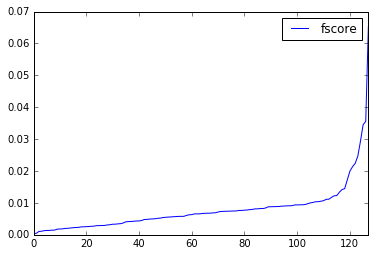

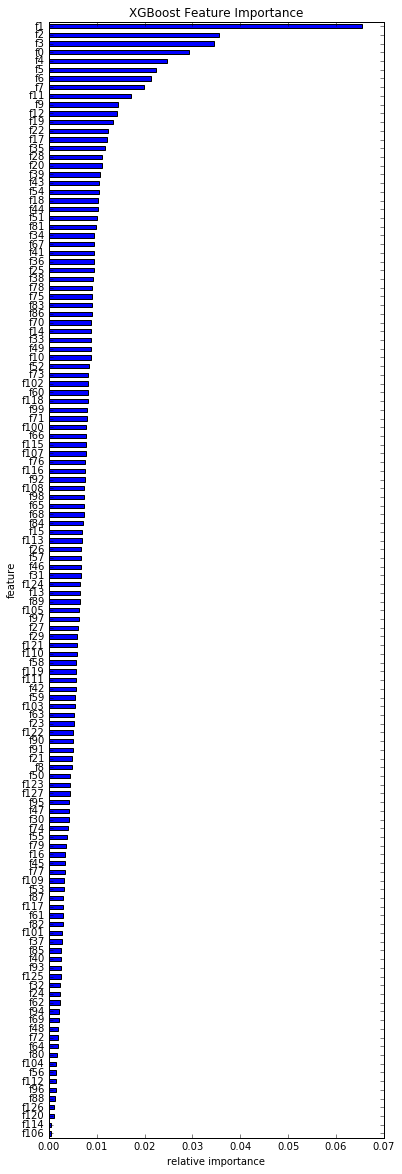

In [70]:
import operator
import pandas as pd

importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 20))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')